# 计算机模拟第三周作业

In [1]:
from __future__ import print_function, division

# 这句话是非标准的python，用于ipthon或jupyter这样的系统中，表示绘图即刻自动展开。
%matplotlib inline

# 这里把全部Warning过滤掉了. 
# 参见https://docs.python.org/2/library/warnings.html
import warnings
warnings.filterwarnings('ignore')
from scipy.special import comb, perm
from scipy import stats
import numpy as np
import sys
import matplotlib.pyplot as plt
np.random.seed(250)

## 问题一

**求证**：
$$ P(S_L)=\frac{1}{2}+(1+\sqrt{2}){e^{-(1+\sqrt{2})}} $$
$$ P(S_U)=\frac{13}{8}-16e^{-3} $$

**证明**：
在 AR 法抽取标准半正态分布中：
$$ g(x)=e^{-\frac{(x-1)^2}{2}} $$
$$ h(x) = e^{-x}, x \geq 0 $$

并且：
$$ g_L(x)=\frac{1-(x-1)^2}{2} $$
$$ g_U(x)=1-\frac{(x-1)^2}{2}+\frac{(x-1)^4}{8} $$

先解：$ g_L(x) \geq 0 $，
得：$x \in [1 - \sqrt{2}, 1 + \sqrt{2}]$

从而：
\begin{equation}
\begin{split}
P(S_L) &= \int_{0}^{1+\sqrt{2}}{g_L(x)h(x)}dx\\
&=\int_{0}^{1+\sqrt{2}}{(1 - \frac{(x-1)^2}{2})e^{-x}}dx\\
&=\int_{0}^{1+\sqrt{2}}{\frac{1+2x-x^2}{2}e^{-x}}dx \\
&=[\frac{x^2-1}{2}e^{-x}]_{0}^{1+\sqrt{2}}\\
&=\frac{1}{2}+(1+\sqrt{2}){e^{-(1+\sqrt{2})}}
\end{split}
\end{equation}

类似的，先解：$ g_U(x) \leq 1 $，
得：$x \in [-2, 3]$

因此：
\begin{equation}
\begin{split}
P(S_U) &= 1 - \int_{0}^{3}{(1 - g_U(x))h(x)}dx\\
&=1 - \int_{0}^{3}{(\frac{(x-1)^2}{2}-\frac{(x-1)^4}{8})e^{-x}}dx\\
&=1 - \int_{0}^{3}{\frac{e^{-x}}{8}(-x^4 + 4x^3 - 2x^2 - 4x + 3)}dx \\
&=1 + [\frac{e^{-x}}{8}(x^4 + 2x^2 + 8x + 5)]_{0}^{3}\\
&=\frac{13}{8}-16e^{-3}
\end{split}
\end{equation}

## 问题二

编程实现这个例子。

+ X：产生的正态分布
+ k：实际接受总数
+ t：实际计算 g 的次数

In [2]:
def sample_normal(N):
# N, 实际采样数
    k = 0  # 实际接受总数
    t = 0  # 实际计算 g(x) 次数
    U = np.random.rand(N)  # 产生均匀分布
    X = [-np.log(u) for u in U]  # 产生服从h的随机变量X
    U = np.random.rand(N)  # 产生均匀分布 eta
    for i in range(N):
        GL = (1-((X[i]-1)**2)/2) # 计算 GL(x[i])
        flag = False  # 布尔变量，用于指示是否接受
        if U[i] <= GL:  # eta <= GL(x[i])
            flag = True  # 接受
        else:  # eta >= GL(x[i])
            GU = GL + ((X[i]-1)**4)/8  # 计算 GU(x[i])
            if U[i] <= GU:  # eta <= GU(x[i])
                G = np.exp(-(X[i]-1)**2/2)  # 计算 G(x[i])
                t = t + 1  # 实际计算 g(x) 次数增 1
                if U[i] <= G:  # eta <= G(x[i])
                    flag = True  # 接受
        if flag:  # 接受，产生正态分布
            w = np.random.rand()
            if w <= 0.5:
                X[k] = X[i]
            else:
                X[k] = -X[i]
            k = k + 1
    return X, k, t

+ 对实际抽样结果进行统计，并将统计分布和理论概率密度分布进行比较。

如下所示。

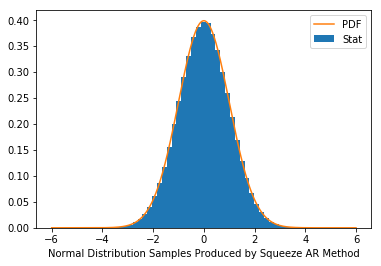

In [3]:
N = 1000000
X, k, t = sample_normal(N)
x = np.linspace(-6,6,10000)
plt.hist(X[0:k], bins=50,normed=True, label="Stat");
plt.plot(x,1/np.sqrt(2*np.pi)*np.exp(-x**2/2), label=r"PDF")
plt.legend()
plt.xlabel(r"Normal Distribution Samples Produced by Squeeze AR Method")
plt.savefig('normal.pdf')

+ 统计实际计算 $g(x)$ 的频率，并和理论值进行比较。

理论值为：

$$N(P(S_U) - P(S_L)) \approx 10^6 \times (0.8284 - 0.7159) = 112500 $$

而实际值为：

In [4]:
t

112820

可见实际值与理论值十分接近。

+ 对统计的结果给出结论。

由上述结果可知，原本 AR 法每次取样中都需要计算 $g(x)$ (正态抽样中这是一个指数计算)。使用挤压法之后，有将近 88.75% 的概率不需要计算 $g(x)$，而仅仅需要计算 $g_L(x)$ 与 $g_U(x)$ (上述例子中为多项式)即可。这对运算速度是一个不小的提升，尤其是取样次数增多的时候。